# Digitalt Spektrum

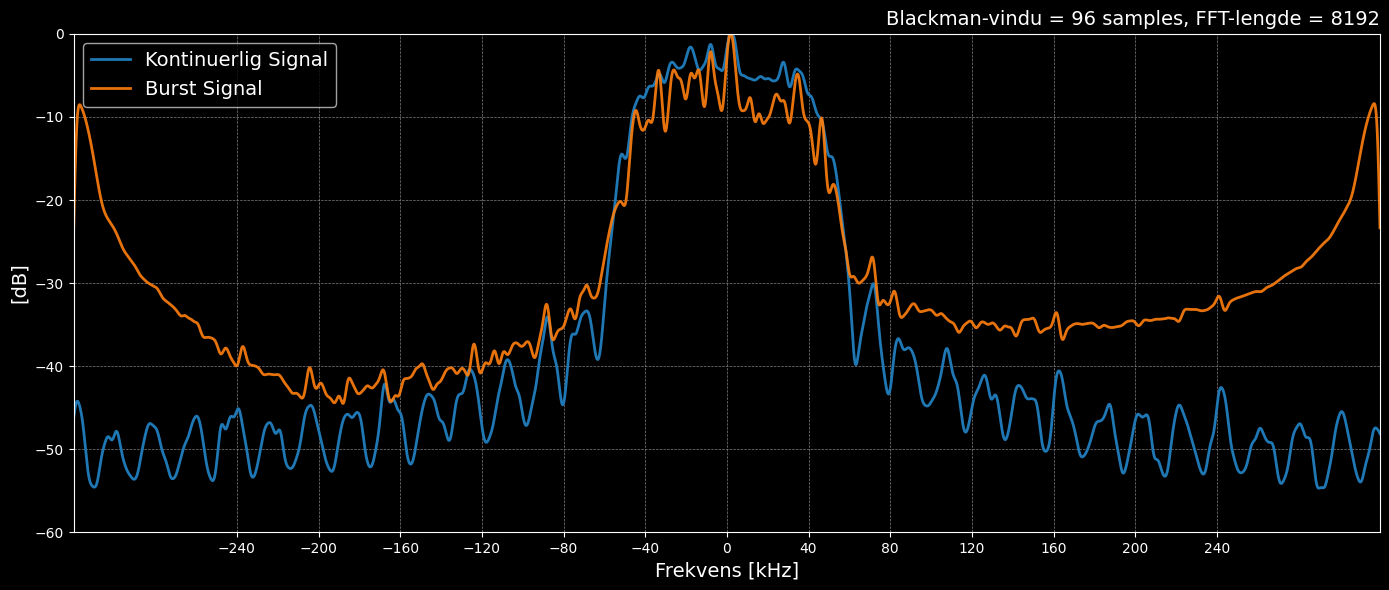

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# === PARAMETRE ===
filnavn_kont = 'SimData/TxKontData.bin'
filnavn_burst = 'SimData/TxBurstData.bin'
samp_rate = 640e3
fft_len = 8192                 # Endre for FFT-oppløsning
window_size = 96             # Glattingsvindu (antall samples)
window_func_name = 'blackman'     # Velg mellom: 'hann', 'blackman', 'hamming', 'bartlett', ...

# === VELG VINDUSFUNKSJON ===
window_functions = {
    'hann': np.hanning,
    'blackman': np.blackman,
    'hamming': np.hamming,
    'bartlett': np.bartlett
}

# Fallback hvis ukjent navn
window_func = window_functions.get(window_func_name.lower(), np.hanning)
filter_window = window_func(window_size)
filter_window /= filter_window.sum()

# === LAST INN DATA ===
kont_data = np.fromfile(filnavn_kont, dtype=np.complex64)
burst_data = np.fromfile(filnavn_burst, dtype=np.complex64)
t = np.arange(len(kont_data)) / samp_rate * 1000  # ms

# --- Funksjon for trygg log10-konvertering ---
def log_power_spectrum(spectrum):
    spectrum_magnitude = np.abs(spectrum)
    spectrum_magnitude[spectrum_magnitude == 0] = 1e-100  # Setter nullverdier til det minste positive tallet
    return 20 * np.log10(spectrum_magnitude)

# --- FFT og spektrum ---
spektrum_kont = np.fft.fftshift(np.fft.fft(kont_data, n=fft_len))
spektrum_kont_dB = log_power_spectrum(spektrum_kont)
spektrum_kont_dB = np.convolve(spektrum_kont_dB, filter_window, mode='same')
spektrum_kont_dB -= spektrum_kont_dB.max()

# --- Burst-spektrum ---
spektrum_burst = np.fft.fftshift(np.fft.fft(burst_data, n=fft_len))
spektrum_burst_dB = log_power_spectrum(spektrum_burst)
spektrum_burst_dB = np.convolve(spektrum_burst_dB, filter_window, mode='same')
spektrum_burst_dB -= spektrum_burst_dB.max()

freqs = np.fft.fftshift(np.fft.fftfreq(fft_len, 1/samp_rate)) / 1e3


# === PLOTTING ===
colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14, 6))
plt.plot(freqs, spektrum_kont_dB, color=colors[0], label='Kontinuerlig Signal', linewidth=2)
plt.plot(freqs, spektrum_burst_dB, color=colors[1], label='Burst Signal', linewidth=2, alpha=0.9)

plt.annotate(f'{window_func_name.title()}-vindu = {window_size} samples, FFT-lengde = {fft_len}', 
             xy=(1, 1.01), xycoords='axes fraction', fontsize=14, ha='right', va='bottom')
plt.xlabel('Frekvens [kHz]', fontsize=14)
plt.ylabel('[dB]', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(np.arange(-240, 241, 40))
plt.xlim(min(freqs), max(freqs))
plt.yticks(np.arange(-60, 1, 10))
plt.ylim(-60, 0)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('Figurer/Tx_spektrum.pdf', format="pdf", bbox_inches='tight')
plt.show()

# Målt Spektrum

## Loop-back

Spektrumseffekt:
Kont: -38.71 dBW
Burst: -42.04 dBW


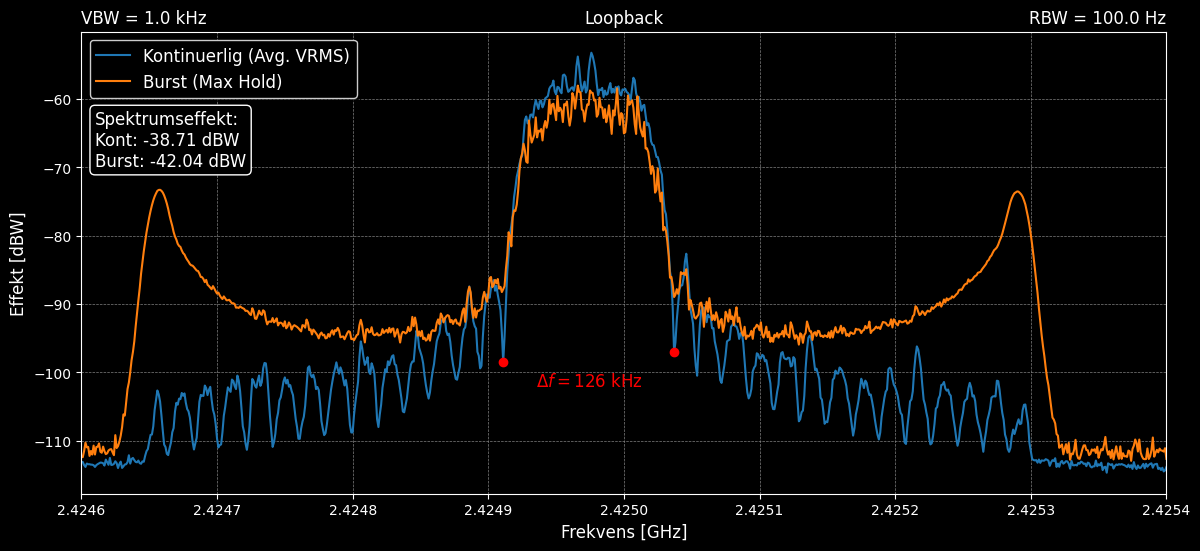

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumLoopBack.csv",
    "Måling/BurstSpektrumLoopBack.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig (Avg. VRMS)', 'Burst (Max Hold)']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]'] + 30 # Attenuator + 30 dB

P_ut_str="Spektrumseffekt:"
temp_keys = ['Kont', 'Burst']
for key,tkey in zip(keys,temp_keys):
    utgangseffekt = 10* np.log10(np.sum(10 ** (spektrum[key]['Power [dBW]'] / 10)))
    P_ut_str += f'\n{tkey}: {utgangseffekt:.2f} dBW'

print(P_ut_str)

# --- FINN MINIMA UNDER -80 dBW I 'Kontinuerlig' SPEKTRUM ---
key0 = keys[0]
df0 = spektrum[key0]

# 1) Begrens til vindu
mask = df0['Frequency[GHz]'].between(2.42491, 2.42504)
df_win = df0[mask]

# 2) Inverter for å finne minima som peaks
inverted = -df_win['Power [dBW]']

# 3) Finn peaks i det inverterte signalet (dvs. minima under -80 dBW)
#    height=80 siden -(-80) = +80
locs, props = find_peaks(inverted, height=80)

# 4) Gå tilbake til original-indekser og plukk ut frekvens/effekt
minima_idx   = df_win.index[locs]
minima_freqs = df0.loc[minima_idx, 'Frequency[GHz]']
minima_pows  = df0.loc[minima_idx, 'Power [dBW]']


# --- Find bandiwdth at threshold -85 dBW within freq range for both --- #

for key in keys:
    df = spektrum[key]
    mask = df['Frequency[GHz]'].between(2.42491, 2.42504)
    df_win = df[mask]

    # Finn peaks i det inverterte signalet (dvs. minima under -80 dBW)
    inverted = -df_win['Power [dBW]']
    locs, props = find_peaks(inverted, height=85)

    # Gå tilbake til original-indekser og plukk ut frekvens/effekt
    minima_idx   = df_win.index[locs]
    minima_freqs = df.loc[minima_idx, 'Frequency[GHz]']
    minima_pows  = df.loc[minima_idx, 'Power [dBW]']

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)

plt.scatter(minima_freqs, minima_pows, color='red', marker='o',zorder=2)
plt.annotate(r'$\Delta f ='+f'{(minima_freqs.iloc[1]-minima_freqs.iloc[0])*1e6:.0f}$ kHz', xy=((minima_freqs.iloc[1]+minima_freqs.iloc[0])/2, minima_pows.iloc[0]), xytext=(0.5, -20), textcoords='offset points',
            fontsize=12, ha='center', va='bottom', color='red')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Loopback', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')

plt.annotate(P_ut_str, xy=(0.0125, 0.83), xycoords='axes fraction', fontsize=12, ha='left', va='top',bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='black'))

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
#plt.xticks(np.arange(2.424, 2.426, 0.001))
plt.xlim(2.4246, 2.4254)
plt.legend(loc='upper left', fontsize=12, shadow=True, fancybox=True)
#plt.savefig('Figurer/LoopbackSpektrum.pdf', bbox_inches='tight')
plt.show()

## Antenne

Kontinuerlig (Avg. VRMS) utgangseffekt: -102.95 dBW
Burst (Max Hold) utgangseffekt: -104.36 dBW


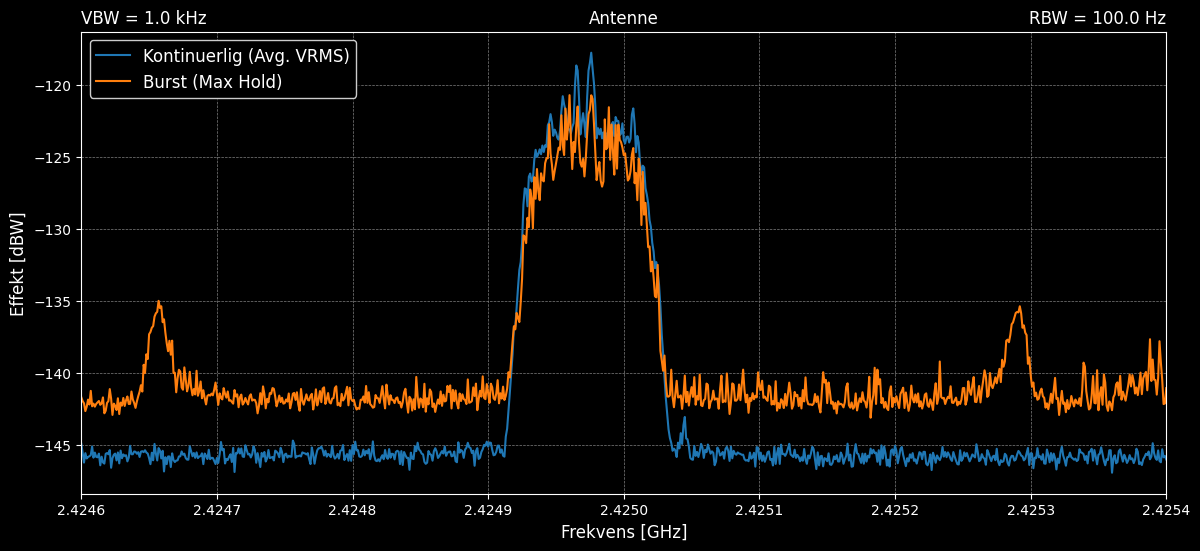

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

file_paths = [
    "Måling/KontSpektrumAntenne.csv",
    "Måling/BurstSpektrumAntenne.csv",]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['Kontinuerlig (Avg. VRMS)', 'Burst (Max Hold)']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]']


utgangseffekt = {'PlutoK': 0, 'PlutoM': 0} # dBm
for key in keys:
    utgangseffekt[key] = 10* np.log10(np.sum(10 ** (spektrum[key]['Power [dBW]'] / 10)))
    print(f'{key} utgangseffekt: {utgangseffekt[key]:.2f} dBW')

colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14,6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)
            

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Antenne', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')
#plt.xticks(np.arange(2.4246, 2.4254, 0.00005),)
#plt.yticks(np.arange(-135, -54, 5))
plt.xlim(2.4246, 2.4254)
#plt.ylim(-135, -55)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12, shadow=True, fancybox=True)
plt.savefig('Figurer/LoopbackSpektrum.pdf', bbox_inches='tight')
plt.show()

# Sinus Loopback

Peak offset: 5.50 kHz
Maximum power: -35.63 dBW
Maximum frequency: 2424984500.000000 GHz
Intermodulasjonsprodukt: -92.56 dBW, Frekvens: 2.424923 GHz, Delta f: -61.5 kHz
Intermodulasjonsprodukt: -82.75 dBW, Frekvens: 2.424945 GHz, Delta f: -40.0 kHz
Intermodulasjonsprodukt: -89.59 dBW, Frekvens: 2.424977 GHz, Delta f: -8.0 kHz
Intermodulasjonsprodukt: -88.65 dBW, Frekvens: 2.424993 GHz, Delta f: 8.0 kHz
Intermodulasjonsprodukt: -89.40 dBW, Frekvens: 2.425047 GHz, Delta f: 62.0 kHz


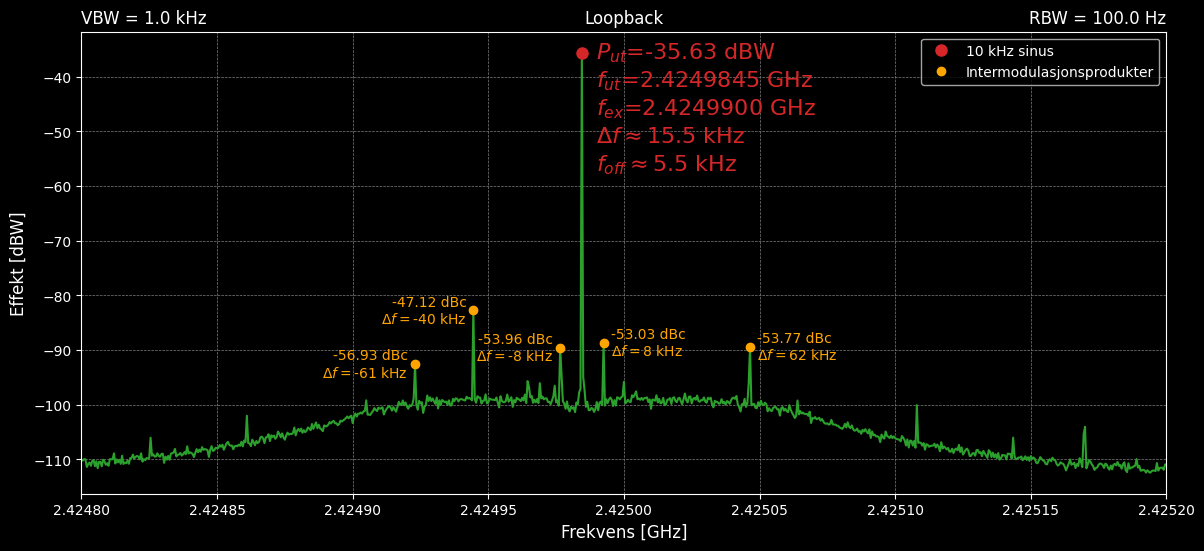

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
plt.style.use('dark_background')

filnavn = "Måling/Sinus10kHz.csv"
RBW = 100  # Hz
VBW = 1000  # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = pd.read_csv(filnavn, sep=',', names=columns, skiprows=154)
spektrum['Frequency[GHz]'] = spektrum['Frequency[Hz]'] / 1e9
spektrum['Power [dBW]'] = spektrum['Power [dBW]'] + 30  # Attenuator + 30 dB

# Finn hovedtoppen
max_power = spektrum['Power [dBW]'].max()
max_power_index = spektrum['Power [dBW]'].idxmax()
max_freq = spektrum['Frequency[Hz]'][max_power_index]

# Peak offset
f_c = 2.425e9
f_expected = f_c - 10e3
peak_offset = np.abs(max_freq - f_expected) / 1e3
print(f'Peak offset: {peak_offset:.2f} kHz')
print(f'Maximum power: {max_power:.2f} dBW')
print(f'Maximum frequency: {max_freq:.6f} GHz')

# Finn alle topper
peaks, _ = find_peaks(spektrum['Power [dBW]'], height=-95)  # juster høyde om nødvendig
peaks_freqs = spektrum['Frequency[GHz]'].iloc[peaks]
peaks_powers = spektrum['Power [dBW]'].iloc[peaks]

# Fjern hovedtoppen fra lista (vi har allerede markert den rødt)
peak_freqs_other = peaks_freqs[peaks_freqs != max_freq / 1e9]
peak_powers_other = peaks_powers[peaks_freqs != max_freq / 1e9]

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(spektrum['Frequency[GHz]'], spektrum['Power [dBW]'], linestyle='-', color='tab:green')
plt.plot(max_freq / 1e9, max_power, 'o', color="tab:red", markersize=8, label='10 kHz sinus')
plt.plot(peak_freqs_other, peak_powers_other, 'o', color="orange", markersize=6, label='Intermodulasjonsprodukter')
for power, freq in zip(peak_powers_other, peak_freqs_other):
    delta_f_kHz = (freq - max_freq / 1e9) * 1e6  # fra GHz til kHz
    delta_P = power- max_power
    if delta_f_kHz < 0:
        ha_str="right"
        x_cord = -5
    else:
        ha_str="left"
        x_cord=5
    plt.annotate(f'{delta_P:.2f} dBc\n'+r'$\Delta f=$'+f'{delta_f_kHz:.0f} kHz', 
                 xy=(freq, power), 
                 xytext=(x_cord, 0), 
                 textcoords='offset points', 
                 color="orange", 
                 fontsize=10, 
                 ha=ha_str, 
                 va='center')
    
    
    print(f'Intermodulasjonsprodukt: {power:.2f} dBW, Frekvens: {freq:.6f} GHz, Delta f: {delta_f_kHz:.1f} kHz')

plt.annotate(r'$P_{ut}$=' + f'{max_power:.2f} dBW', xy=(max_freq / 1e9, max_power), xytext=(10, 0), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{ut}$=' + f'{max_freq/1e9:.7f} GHz', xy=(max_freq / 1e9, max_power), xytext=(10, -20), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{ex}$=' + f'{f_expected/1e9:.7f} GHz', xy=(max_freq / 1e9, max_power), xytext=(10, -40), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$\Delta f\approx$' + f'{(f_c-max_freq)/1e3:.1f} kHz', xy=(max_freq / 1e9, max_power), xytext=(10, -60), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')
plt.annotate(r'$f_{off}\approx$' + f'{peak_offset:.1f} kHz', xy=(max_freq / 1e9, max_power), xytext=(10, -80), textcoords='offset points', color="tab:red", fontsize=16, ha='left', va='center')

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right', va='bottom')
plt.annotate('VBW = {:.1f} kHz'.format(VBW / 1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left', va='bottom')
plt.annotate('Loopback', xy=(0.5, 1.01), xycoords='axes fraction', fontsize=12, ha='center', va='bottom')
plt.xlim(2.4248, 2.4252)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend()
plt.savefig('Figurer/Sinus10kHz.pdf', bbox_inches='tight')
plt.show()
